In [8]:
from fastai.vision.all import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import string
import PIL.ImageOps
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns
import torch
import matplotlib.pyplot as plt

In [2]:
# Function to preprocess the input image
def preprocess_image(image_path, white_on_black=True):
    img = Image.open(image_path).convert('L')  # Convert to grayscale
    if white_on_black:
        img = PIL.ImageOps.invert(img)  # Invert the image (if necessary)
    img = img.resize((28, 28))  # Resize to match the model input size
    img = np.array(img)  # Convert to NumPy array
    img = img / 255.0  # Normalize pixel values to the range [0, 1]
    if not white_on_black:
        img = 1.0 - img  # Invert pixel values (if necessary)
    img_rgb = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB format
    img_rgb = np.transpose(img_rgb, (2, 0, 1))  # Reshape to (C, H, W)
    tensor_img = torch.tensor(img_rgb, dtype=torch.float32)
    if torch.cuda.is_available():
        tensor_img = tensor_img.cuda()  # Move tensor to GPU if available
    return tensor_img


In [3]:
# Load the CSV file containing the pixel values
letters_df = pd.read_csv("/kaggle/input/az-handwritten-alphabets-in-csv-format/A_Z Handwritten Data.csv")

# Map integer labels to corresponding letters
label_mapping = {i: letter for i, letter in enumerate(string.ascii_uppercase)}

# Rename the label column to 'label'
letters_df.rename(columns={'0': 'label'}, inplace=True)


In [4]:
# Split the data into train and test sets
train_df, test_df = train_test_split(letters_df, test_size=0.2, random_state=42)

# Subset the training data
train_df = train_df.sample(frac=0.5, random_state=42)

def convert_to_image(pixels):
    img = np.array(pixels, dtype=np.uint8).reshape((28, 28))
    return PILImage.create(img)

def get_x(r):
    return convert_to_image(list(r[1:]))

def get_y(r):
    return label_mapping[r['label']]

data = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_x,
    get_y=get_y,
    splitter=RandomSplitter(),
    item_tfms=Resize(28),
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)]
)


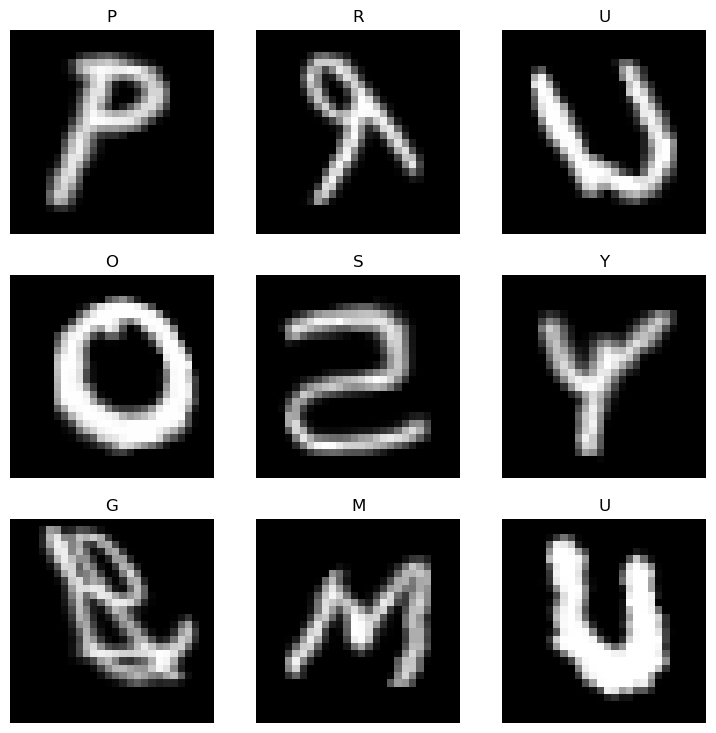

In [5]:
# Create dataloaders
dls = data.dataloaders(train_df)

# Display samples of training data
dls.show_batch()



/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd

epoch,train_loss,valid_loss,accuracy,time
0,0.909765,0.678021,0.789267,04:15


epoch,train_loss,valid_loss,accuracy,time
0,0.268162,0.163915,0.950262,04:27
1,0.201070,0.124422,0.963754,04:27
2,0.132063,0.095435,0.972345,05:21
3,0.122101,0.079208,0.976641,06:20
4,0.095414,0.074185,0.977849,04:53


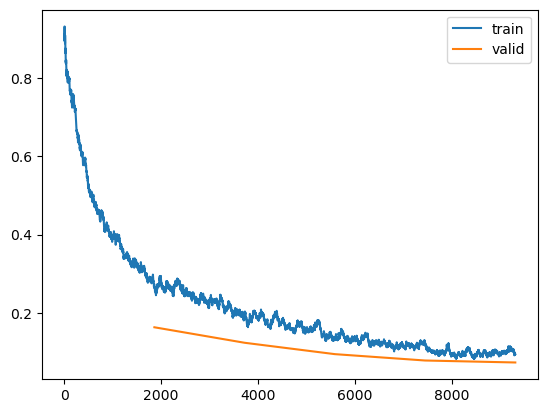

In [6]:
# For example, let's use a simple CNN model to train the data:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.fine_tune(epochs=5)
learn.recorder.plot_loss()

In [7]:
learn.export("/kaggle/working/learner_object.pkl")

In [23]:
image_path = "/kaggle/input/biggero/Oimage1.jpg"
def preprocess_input_image(image_path, white_on_black=True):
    img_pil = Image.open(image_path).convert('L')  # Convert to grayscale
    if white_on_black:
        img_pil = PIL.ImageOps.invert(img_pil)  # Invert the image (if necessary)
    img_pil = img_pil.resize((28, 28))  # Resize to match the model input size
    img_pil = np.array(img_pil)  # Convert to NumPy array
    img_pil = img_pil / 255.0  # Normalize pixel values to the range [0, 1]
    if not white_on_black:
        img_pil = 1.0 - img_pil  # Invert pixel values (if necessary)
    img_pil_rgb = np.stack((img_pil,) * 3, axis=-1)  # Convert grayscale to RGB format
    img_pil_rgb = np.transpose(img_pil_rgb, (2, 0, 1))  # Reshape to (C, H, W)
    tensor_img = torch.tensor(img_pil_rgb, dtype=torch.float32)
    tensor_img = tensor_img.unsqueeze(0)  # Add the batch dimension
    if torch.cuda.is_available():
        tensor_img = tensor_img.cuda()  # Move tensor to GPU if available
    return tensor_img, Image.fromarray((img_pil * 255).astype(np.uint8))



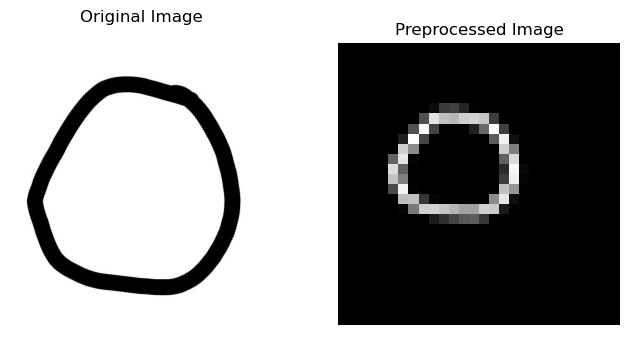

In [24]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(Image.open(image_path), cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(preprocessed_img, cmap='gray')
plt.title("Preprocessed Image")
plt.axis('off')
plt.show()

In [25]:
def classify_letter(image_path):
    preprocessed_tensor, preprocessed_img = preprocess_input_image(image_path)  # Get preprocessed tensor and PIL image
    learn.model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        if torch.cuda.is_available():
            preprocessed_tensor = preprocessed_tensor.cuda()  # Move tensor to GPU if available
        pred = learn.model(preprocessed_tensor)
        class_idx = torch.argmax(pred).item()
        predicted_letter = learn.dls.vocab[class_idx]
    return predicted_letter, preprocessed_img


In [26]:
predicted_letter = classify_letter(image_path)
print("Predicted letter:", predicted_letter)

Predicted letter: ('O', <PIL.Image.Image image mode=L size=28x28>)
